# Computing parallel imaging g-factor using the BART Python interface

Author: Jon Tamir <jtamir@eecs.berkeley.edu>


In this tutorial, we show how the BART command-line tools can be used in Python. We use this to mix both BART and native Python commands. Before running this tutorial, first go through the intro demo.

Data is taken from the ISMRM 2013 Sunrise Course on Parallel Imaging  
http://hansenms.github.io/sunrise/sunrise2013/

For more information, see the following papers:

Kellman, P. and McVeigh, E. R. (2005), Image reconstruction in SNR units: A general method for SNR measurement. Magn. Reson. Med., 54: 1439-1447. doi:10.1002/mrm.20713

Robson, P. M., Grant, A. K., Madhuranthakam, A. J., Lattanzi, R. , Sodickson, D. K. and McKenzie, C. A. (2008), Comprehensive quantification of signal‐to‐noise ratio and g‐factor for image‐based and k‐space‐based parallel imaging reconstructions. Magn. Reson. Med., 60: 895-907. doi:10.1002/mrm.21728


### Requirements
- Install bart (version 0.4.02 or newer): https://github.com/mrirecon/bart  
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`
- Add the BART Python module to the `PYTHONPATH` variable
```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=$TOOLBOX_PATH:$PATH
export PYTHONPATH=/path/to/bart/python:$PYTHONPATH
```
- Install python dependencies:  
`pip install h5py numpy matplotlib`

In [3]:
!export TOOLBOX_PATH=/packages/bart/0.5.00
!export PATH=$TOOLBOX_PATH:$PATH
!export PYTHONPATH=/packages/bart/0.5.00/python:$PYTHONPATH

### Running through MyBinder
MyBinder allows us to run a Jupyter Lab instance through a browser, but requires installing the BART tools first. If using MyBinder, first run the "setup" notebook, then run the following cell:

In [7]:
import sys
import os
#os.environ['TOOLBOX_PATH'] = '/packages/bart/0.5.00'
#os.environ['BART_PATH'] = '/packages/bart/0.5.00'
#sys.path.append('/packages/bart/0.5.00/python')
#os.environ

## Running BART commands in Python

BART commands are run with the python module under `bart/python/bart.py`. This module writes data to disk with `cfl.writecfl`, runs a bart command in the shell, and then loads the result with `cfl.readcfl`. This leads to large writes to disk, which can be slow. It is suggested to make a RAM disk to speed this up.

Alternatively, the master branch has an experimental interface called `pyBART`, which does not write to disk. However, it is not yet in a finished state.

After importing bart, commands are run like this:
```python
out1, out2, out3 = bart(3, 'command -x arg1 -y arg2 -z arg3', input1, input2)
```
Here, the first argument tells bart that three outputs are returned. The second argument is the actual command. The later arguments are the numpy files that the command will use. When running the commands, output will be seen in the terminal/notebook shell.

In [8]:
import numpy as np
import h5py
import time

import cfl
from bart import bart

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

## Load data from hdf5 file
The data is taken from http://hansenms.github.io/sunrise/sunrise2013/ and saved as an hdf5 file. The data are Cartesian k-space prospectively under-sampled with a 1x4 acceleration factor. The sensitivity maps were computed from a pre-scan

In [9]:
print('loading data')

with h5py.File('data.h5', 'r') as F:
    ksp = np.array(F['ksp'])
    sens = np.array(F['sens'])
    mask = np.array(F['mask'])
    noise = np.array(F['noise'])
    
print('done!')
print('ksp shape:', ksp.shape)
nx, ny, nc = ksp.shape

loading data
done!
ksp shape: (256, 256, 8)


We will use the BART FFT interface to take the IFFT of our data. The syntax is the same as the CLI version, except that the first argument specifies the number of outputs, and the inputs are passed after the optional arguments

In [143]:
cimg = bart(1, 'fft -iu 3',ksp*mask[:,:,None]) # compare to `bart fft -iu 3 ksp cimg`

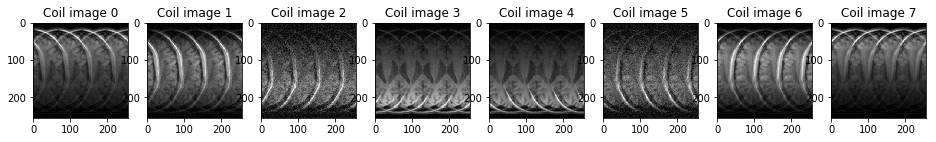

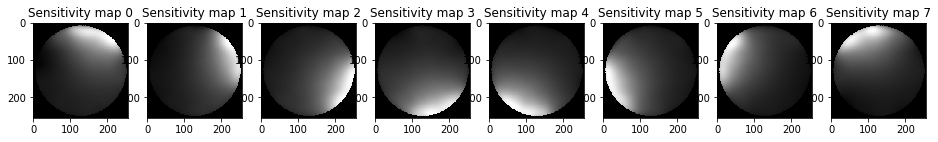

In [139]:
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))
    

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,i]).squeeze(), cmap='gray')
    plt.title('Sensitivity map {}'.format(i))

## Noise whitening
Notice that some coil images have higher noise than others. We can estimate the noise covariance matrix from our noise measurements and apply a noise pre-whitening matrix. We need to apply it to both the data and the sensitivity maps

Text(0.5,1,'Covariance matrix after pre-whitening')

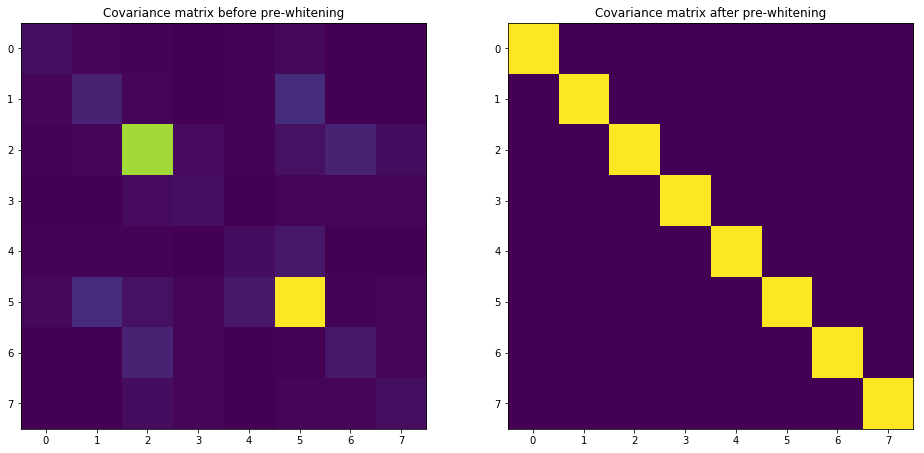

In [13]:
noise_flat = np.reshape(noise, (-1, nc))
cov = np.dot(np.conj(noise_flat).T, noise_flat)


noise_white = bart(1, 'whiten', noise_flat[:,None,None,:], noise_flat[:,None,None,:]).reshape((-1, nc))
ksp_white = bart(1, 'whiten', ksp[:,:,None,:], noise_flat[:,None,None,:]).squeeze()
sens_white = bart(1, 'whiten', sens[:,:,None,:], noise_flat[:,None,None,:]).squeeze()

cov_white = np.dot(np.conj(noise_white).T, noise_white)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(cov.squeeze()))
plt.title('Covariance matrix before pre-whitening')
plt.subplot(1, 2, 2)
plt.imshow(abs(cov_white.squeeze()))
plt.title('Covariance matrix after pre-whitening')


Notice that after pre-whitening, the noise levels are equalized. This is evident in both the noise covariance matrix, as well as the coil images, seen below:

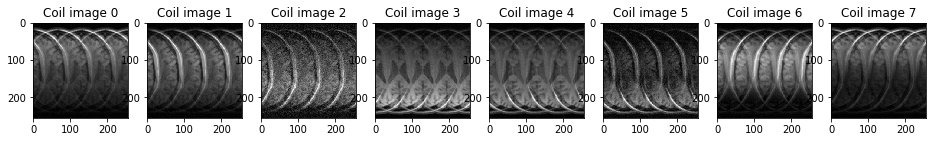

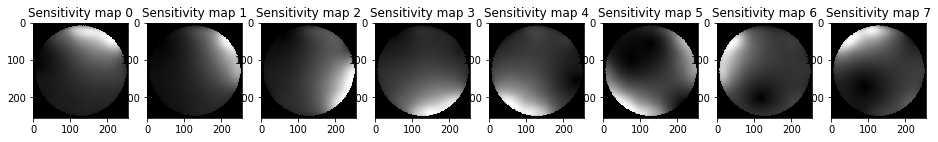

In [14]:
cimg_white = bart(1, 'fft -iu 3', ksp_white).squeeze()
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg_white[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))
    
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens_white[:,:,i]).squeeze(), cmap='gray')
    plt.title('Sensitivity map {}'.format(i))

## Visualize the sampling pattern

Acceleration factor: 4.0


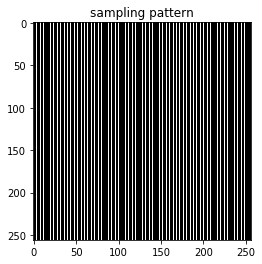

In [23]:
assert np.linalg.norm(mask - (np.linalg.norm(ksp, axis=2) != 0)) < 1E-5, 'mask does not match data!'
    
plt.figure(figsize=(4, 4))
plt.imshow(mask, cmap='gray')
plt.title('sampling pattern')

R = np.prod(np.shape(mask)) / np.sum(mask)
print('Acceleration factor: {}'. format(R))

## Reconstruct the data before and after noise whitening
We will use the `pics` tool to perform a parallel imaging reconstruction with no regularization.

Text(0.5,1,'Reconstruction after noise whitening')

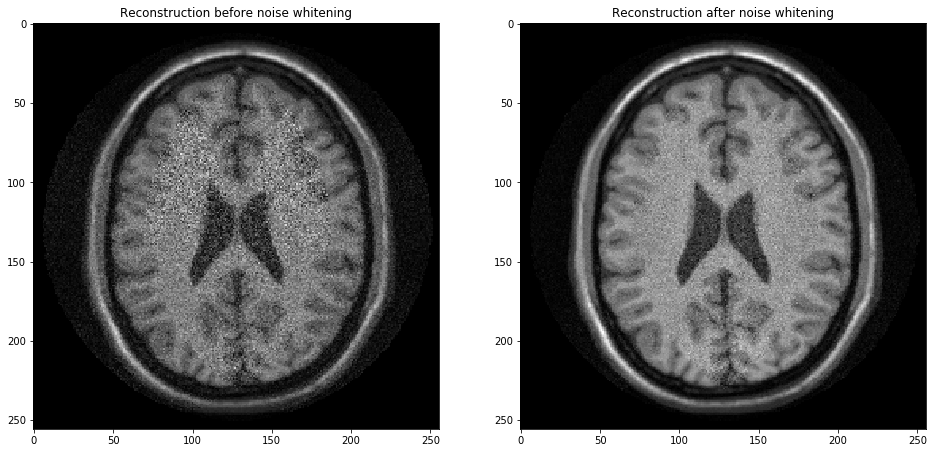

In [27]:
reco = bart(1, 'pics -S -i 150', ksp[:,:,None,:], sens[:,:,None,:])
reco_white = bart(1, 'pics -S -i 30', ksp_white[:,:,None,:], sens_white[:,:,None,:])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

plt.imshow(abs(reco).squeeze(), cmap='gray')
plt.title('Reconstruction before noise whitening')

plt.subplot(1, 2, 2)
plt.imshow(abs(reco_white).squeeze(), cmap='gray')
plt.title('Reconstruction after noise whitening')


The reconstruction after noise-whitening is improved.

## Estimate G-factor
In parallel imaging, noise is amplified in the reconstruction in a spatially-varying way that depends on the specific geometry of the coils. This is formalized with the g-factor.

### Pseudo Multiple Replica Method
We can estimate the g-factor through a Monte Carlo approach, where we perform many reconstructions on different instances of noise. As a side-benefit, we can also scale the reconstruction to SNR units.

The setup is the following:
1. Add noise to kspace and reconstruct. Repeat N_MC times
2. Reconstruct noise without kspace and without under-sampling. Repeat N_MC times
3. g_factor = std((1)) / (std((2)) * sqrt(R))

We will use bart to perform the reconstructions


## Repeat reconstruction with N_MC noise instances

In [21]:
!bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <string>] [-n] [-g] [-G d] [-p <string>] [-I ...] [-b d] [-e] [-T <string>] [-W <string>] [-d d] [-O d] [-o f] [-u f] [-C d] [-q f] [-f f] [-m ...] [-w f] [-S] [-B d] [-K] [-P f] [-a ...] [-M] <kspace> <sensitivities> <output>

Parallel-imaging compressed-sensing reconstruction.

-l1/-l2		toggle l1-wavelet or l2 regularization.
-r lambda      	regularization parameter
-R <T>:A:B:C	generalized regularization options (-Rh for help)
-c		real-value constraint
-s step      	iteration stepsize
-i iter      	max. number of iterations
-t file      	k-space trajectory
-n		disable random wavelet cycle spinning
-g		use GPU
-G gpun      	use GPU device gpun
-p file      	pattern or weights
-I		select IST
-b blk      	Lowrank block size
-e		Scale stepsize based on max. eigenvalue
-T file      	(truth file)
-W <img>      	Warm start with <img>
-d level      	Debug level
-O rwiter      	(reweighting)
-o gamma      	(reweighting)
-u rho      

In [25]:
(np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)).shape
mask[:,:,None].shape

(256, 256, 1)

In [28]:
n_mc = 30

recons = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):

    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    ksp_noise = mask[:,:,None] * (ksp_white + ksp_noise)
    
    recons[:,:,i] = bart(1, 'pics -S -i 100', ksp_noise[:,:,None,:], sens_white[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (58.11329650878906 s)


## Repeat reconstruction with N_MC noise-only instances
Remember that there are two sources of noise in paralell imaging: geometry-based noise amplifcation and lower SNR due to less sampling. To account for the second effect, we run the noise-only instances through a reconstruction with no acceleration (no sampling mask)

In [29]:
recons_noise = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):
    
    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    recons_noise[:,:,i] = bart(1, 'pics -S -i 25', ksp_noise[:,:,None,:], sens_white[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (23.514317750930786 s)


## Compute g-factor

Max g-factor value: 7.29307687151387


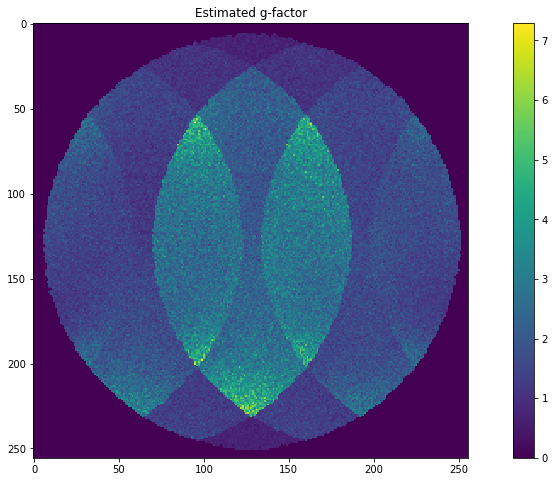

In [30]:
recons_std = np.std(recons.real, axis=2)
recon_noise_std = np.std(recons_noise, axis=2)

gfactor = np.divide(recons_std, recon_noise_std, where=abs(recons[:,:,0].squeeze()) != 0) / np.sqrt(R)

max_gf = np.max(gfactor)

print('Max g-factor value: {}'.format(max_gf))


plt.figure(figsize=(16, 8))
plt.imshow(gfactor, vmax=max_gf)
plt.title('Estimated g-factor')
plt.colorbar()